Author: Aydin Najl Hossaini  
Date: 24/08/2024

# Imports

In [28]:
import pandas as pd
from tqdm.notebook import tqdm
import os
from sklearn.preprocessing import MinMaxScaler


In [2]:
# All game ids in pbp_games folder
game_names = [name for name in os.listdir("pbp_games") if name.endswith("csv")]

game_ids = [id for id in range(1, len(game_names) + 1)]
game_id_map = dict(zip(game_names, game_ids))



# Data processing

## Options

In [3]:
pd.options.mode.copy_on_write = True # Allows for chained assignment 
LBJ_life_ft_percent = 73.6

## Game ids

In [4]:
# All game ids in pbp_games folder
game_names = [name for name in os.listdir("pbp_games") if name.endswith("csv")]

game_ids = [id for id in range(1, len(game_names) + 1)]
game_id_map = dict(zip(game_names, game_ids))


In [5]:
# Test one game
game = pd.read_csv("pbp_games/2017_11_7_CLE_PBP_HOME.csv")
game.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   period                       432 non-null    int64  
 1   period_type                  432 non-null    object 
 2   remaining_seconds_in_period  432 non-null    float64
 3   relevant_team                432 non-null    object 
 4   away_team                    432 non-null    object 
 5   home_team                    432 non-null    object 
 6   away_score                   432 non-null    int64  
 7   home_score                   432 non-null    int64  
 8   description                  432 non-null    object 
dtypes: float64(1), int64(3), object(5)
memory usage: 30.5+ KB


In [6]:

# TODO: Add game id column to each game

# for name, id in game_id_map.items():
#     game = pd.read_csv("pbp_games/" + name)
#     game["game_id"] = id
    


## Decide on features
 1. Time remaining in the quarter
 2. Score difference
 3. Home/Away team
 4. Period
 5. how many made shots in the game (=FG%)  
     Obtain this through the description column and filter for "makes" and "misses" on player level
        Notable words:  
        misses 2-pt  
        misses 3-pt  
        misses free throw  
        makes free throw  
        makes 2-pt  
        makes 3-pt  
6. minutes played


In [7]:
# Add unique event id for join
def add_event_id_col(game : pd.DataFrame):
    game["event_id"] = range(1, len(game) + 1)
    return game

In [8]:
# Transfer period type + remaining_seconds_in_period to a time format
# Full quarter has 720 seconds, therefore 720 - remaining_seconds_in_period = seconds played in the quarter
# If quarter is 2, 2*720 - remaining_seconds_in_period ;  3 + 3*720 - ..., 4 + 4*720 - ... 
# Adds game_time passed column
def add_game_time_col(game: pd.DataFrame):
    game["game_time"] = game.apply(lambda x: x['period']*720 - x['remaining_seconds_in_period'], axis=1)
    return game

## Add score difference column

In [9]:
# Necessary function due to some games played away
def game_diff(row):
    """ Calculate the score difference for each game """

    if row["home_team"] == "CLEVELAND CAVALIERS":
        return row["home_score"] - row["away_score"]
    elif row["away_team"] == "CLEVELAND CAVALIERS":
        return row["away_score"] - row["home_score"]
    else:
        raise Exception("Cavs not in the game")
    
# Adds score diff column
def add_score_diff_col(game: pd.DataFrame):
    game["score_diff"] = game.apply(game_diff, axis=1)
    return game

## Plays at home column

In [10]:
# Adds at_home column
def add_at_home_col(game: pd.DataFrame):
    game["at_home"] = game["home_team"] == "CLEVELAND CAVALIERS"
    return game

In [11]:
# Playing time very hard to quantify due to starters and starters of quarters being unknown

# game[game["description"].str.contains("enters the game for L. James")]
# game[game["description"].str.contains("L. James enters the game for")]


## Calculating cum FGM with new DF

In [12]:
def create_fg_df(game: pd.DataFrame):
    '''
    Selects Lebron FGs based on keywords and adds cumulative count of FGs as column
    '''
    # Selects all the field goals made by Lebron
    field_goals = game[game["description"].str.contains("L. James") & game["relevant_team"].str.contains("CLE") 
                    &~ game["description"].str.contains("assist by L. James") &~ game["description"].str.contains("free throw")]
        

    made_mask = field_goals['description'].str.contains('makes 2-pt|makes 3-pt')
    attempted_mask = field_goals['description'].str.contains('makes 2-pt|misses 2-pt|makes 3-pt|misses 3-pt')

    # Adds field goals made and attempted columns
    field_goals.loc[:, 'field_goals_made'] = made_mask.astype(int)
    field_goals.loc[:, 'field_goals_attempted'] = attempted_mask.astype(int)

    # Create cumulative totals columns using .loc
    field_goals.loc[:, 'cumulative_field_goals_made'] = field_goals['field_goals_made'].cumsum()
    field_goals.loc[:, 'cumulative_field_goals_attempted'] = field_goals['field_goals_attempted'].cumsum()
    
    return field_goals

## Merge dataframes to contain all features

In [13]:
def add_fg_cols(game: pd.DataFrame):
    '''
    Create new Dataframe including cum FGM and cum FGA
    '''
    # Create new DF with FGs 
    field_goals = create_fg_df(game)

    # Merge the game and field goals dataframes to get the cumulative field goals made and attempted
    joined_df = pd.merge(game, 
                        field_goals[['event_id', 'cumulative_field_goals_made', 'cumulative_field_goals_attempted']],
                        on='event_id', 
                        how='left')

    # Forward fill the NaN values so highest number is used
    joined_df['cumulative_field_goals_made'] = joined_df['cumulative_field_goals_made'].ffill().fillna(0)
    joined_df['cumulative_field_goals_attempted'] = joined_df['cumulative_field_goals_attempted'].ffill().fillna(0)
    
    return joined_df


## Select free throws rows for prediction

In [14]:
def create_ft_df(joined_df: pd.DataFrame):

    # Select all the free throws attempted by Lebron
    joined_df[joined_df["description"].str.contains("L. James") & joined_df["description"].str.contains("free throw")] # 2. Lebron made 8 free throws in the game
    
    # If madea free throw is in the description, add a column free_throw_made
    joined_df["free_throw_made"] = joined_df["description"].str.contains("makes free throw").astype(int)

    free_throws = joined_df[joined_df["description"].str.contains("L. James") & joined_df["description"].str.contains("free throw")]

    return free_throws

In [15]:
def preprocess_game(game: pd.DataFrame):
    '''
    Adds multiple columns to the dataframe
    '''
    game = add_event_id_col(game)
    game = add_game_time_col(game)
    game = add_score_diff_col(game)
    game = add_at_home_col(game)
    return game

game = preprocess_game(game)
joined_df = add_fg_cols(game)
free_throws = create_ft_df(joined_df)

# free_throws

## Multigame preprocessing

In [71]:
def drop_cols(df):
    columns = ['away_team', 'home_team', 'away_score', 'home_score', 'description', 'relevant_team', 'period_type', "event_id"]
    df["at_home"] = df["at_home"].astype(int)
    return df.drop(columns=columns)

def scale_cols(df):
    cols_to_scale = ['remaining_seconds_in_period', 'score_diff', 
                 'cumulative_field_goals_made', 'cumulative_field_goals_attempted',
                 'game_time']
    df[cols_to_scale] = MinMaxScaler().fit_transform(df[cols_to_scale])
    return df

def one_hot_encode(df):
    all_periods = [1,2,3,4]
    dum_df = pd.get_dummies(df["period"], prefix="period", dtype=int).reindex(columns=[f"period_{p}" for p in all_periods], fill_value=0)
    dum_df = dum_df.join(df)
    df = dum_df.drop(columns=["period"])
    return df

In [72]:
agglomerated_df = pd.DataFrame()

for game, id in game_id_map.items():
    game = pd.read_csv("pbp_games/" + game)
    game = preprocess_game(game)
    joined_df = add_fg_cols(game)
    free_throws = create_ft_df(joined_df)
    X= drop_cols(free_throws)
    X = scale_cols(X)
    X = one_hot_encode(X)
    agglomerated_df = pd.concat([agglomerated_df, X])



In [73]:
agglomerated_df.head(5)

,period_1,period_2,period_3,period_4,remaining_seconds_in_period,game_time,score_diff,at_home,cumulative_field_goals_made,cumulative_field_goals_attempted,free_throw_made
157,0,1,0,0,0.0,0.0,0.923077,1,0.0,0.0,1
158,0,1,0,0,0.0,0.0,1.000000,1,0.0,0.0,1
384,0,0,0,1,1.0,1.0,0.000000,1,1.0,1.0,1
385,0,0,0,1,1.0,1.0,0.076923,1,1.0,1.0,1
207,0,0,1,0,0.0,0.0,0.000000,0,0.0,0.0,1


# Machine Learning

## Imports

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Selecting features 

In [74]:
X = agglomerated_df.drop(columns=["free_throw_made"])
y = agglomerated_df["free_throw_made"]

## Splitting data

In [75]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [76]:
y_train

368    1
166    0
305    1
434    1
61     1
      ..
400    1
463    1
210    1
290    0
112    1
Name: free_throw_made, Length: 398, dtype: int64

## Model development and prediction

In [77]:
logreg = LogisticRegression(random_state=16)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

## Evaluation

In [78]:
# import the metrics class

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  0,  31],
       [  0, 102]])

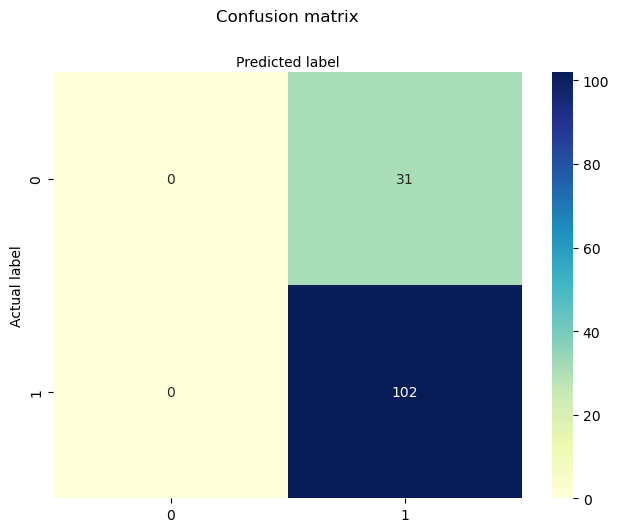

In [84]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

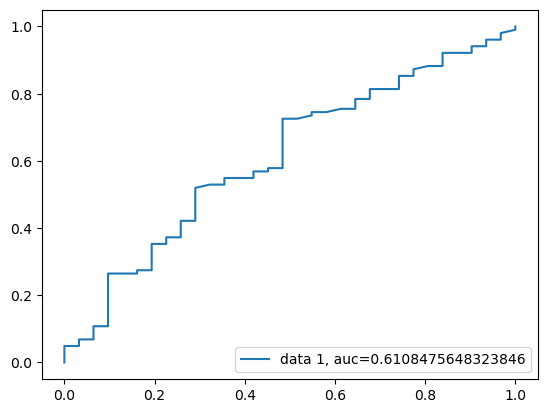

In [85]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [80]:
from sklearn.metrics import classification_report

target_names = ['Made free throw', "Missed free throw"]
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

  Made free throw       0.00      0.00      0.00        31
Missed free throw       0.77      1.00      0.87       102

         accuracy                           0.77       133
        macro avg       0.38      0.50      0.43       133
     weighted avg       0.59      0.77      0.67       133



c:\Users\aydin\anaconda3\envs\bball\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aydin\anaconda3\envs\bball\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aydin\anaconda3\envs\bball\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
